In [1]:
project_name="anime-dcgan"

### Get Dataset

In [2]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/splcher/animefacedataset"
od.download(dataset_url)

100%|██████████| 395M/395M [01:32<00:00, 4.49MB/s] 


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5,0.5),(0.5,0.5,0.5) #normallize RGB to 0.5

In [5]:
train_ds = ImageFolder(root='./animefacedataset',transform=T.Compose([
  T.Resize(image_size), #resize to 64x64
  T.CenterCrop(image_size), #center crop to 64x64
  T.ToTensor(), #convert to tensor
  T.Normalize(*stats)])) #normalize to 0.5 from (0,1) to (-1,1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensor):
  """take image_tensor multiply with standard deviation and add the mean value. Bring it back to (0,1)"""
  return img_tensor * stats[0][1] + stats[0][0]

In [10]:
def show_image(image, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(image.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl,nmax=64):
  for images, _ in dl:
    show_image(images,nmax=nmax)
    break

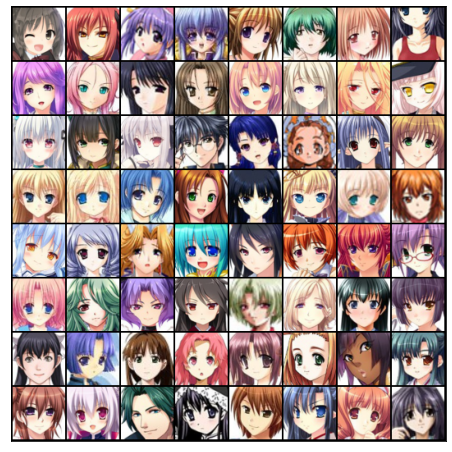

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
  """Pick GPU if possible else CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data,device):
  """move tensor to chosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  """Wrap DataLoader to device"""
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """number of batches"""
    return len(self.dl)



In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl,device)

### Discriminator Network

In [18]:
# Classifier model (DCGAN)
import torch.nn as nn

discirminator = nn.Sequential(
  # input is 3 x 64 x 64
  nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(64),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 64 x 32 x 32
  
  nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 128 x 16 x 16

  nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(256),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 256 x 8 x 8

  nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(512),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 512 x 4 x 4

  nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
  #output is 1 x 1 x 1
  
  nn.Flatten(),
  nn.Sigmoid()  #output is a probability
  # classification use softmax, but generation use sigmoid
)

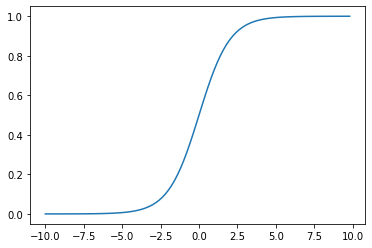

In [17]:
import math
import numpy as np


def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x, sig)
plt.show()


In [19]:
discirminator = to_device(discirminator,device)

In [20]:
latent_size = 128 # controller number, more latent more feature e.g. human face 1024 

In [22]:
generator = nn.Sequential(
  #input: latent_size x 1 x 1
  nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
  nn.BatchNorm2d(512),
  nn.ReLU(inplace=True),
  #output: 512 x 4 x 4

  nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(256),
  nn.ReLU(inplace=True),
  #output: 256 x 8 x 8

  nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(inplace=True),
  #output: 128 x 16 x 16

  nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  #output: 64 x 32 x 32

  nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
  nn.Tanh()
  #output: 3 x 64 x 64
)

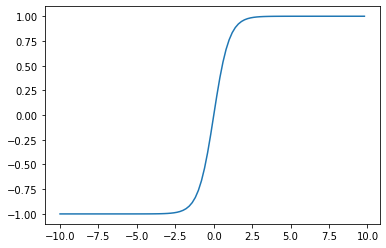

In [21]:
## value from (-1,1)
def tanh(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
tan = tanh(x)
plt.plot(x, tan)
plt.show()

torch.Size([128, 3, 64, 64])


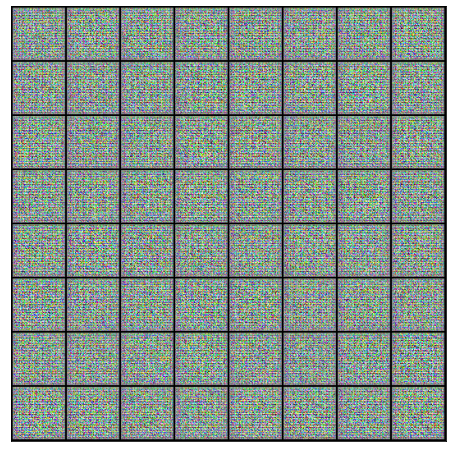

In [23]:
# Create random latent vector
latent = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(latent)
print(fake_images.shape)
show_image(fake_images)

In [24]:
generator = to_device(generator,device)

### Discriminator Network Training

use binary crossentrophy loss

In [26]:
import torch.nn.functional as F

In [27]:
def tarin_discriminator(real_images, opt_d):
    # clear discriminator gradient
    opt_d.zero_grad()

    # pass real images throgh discriminator
    real_preds = discirminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device) #real images always true
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake Images
    latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_target = torch.zeros(real_images.size(0), 1, device=device) # fake images always false
    fake_preds = discirminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_target)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


### Generator Network Training

In [28]:
def train_generator(opt_g):
  # clear generator gradient
  opt_g.zero_grad()

  # generate fake images
  latent = torch.rand(batch_size,latent_size,1,1, device=device)
  fake_images = generator(latent)

  #try to fool the discriminator
  preds = discirminator(fake_images)
  targets = torch.ones(batch_size,1,device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [29]:
from torchvision.utils import save_image
import os
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [30]:
def save_samples(index,latent_tensors,show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{:04d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  print("Saving",fake_fname)
  if show:
    fix, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [ ]:
fixed_latent = torch.randn(64,latent_size,1,1,devicve=device)
save_samples(0,fixed_latent)
